# Анализ А/В теста

**Описание теста:**
- Тестируется новый метод рекомендации постов;
- Время проведения эксперимента с `"2022-05-24"` по `"2022-05-30"` включительно;
- В группе `2` был использован один из новых алгоритмов рекомендации постов, группа `1` использовалась в качестве контроля;
- Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

## Загрузим данные по экспериментальным группам

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import hashlib
import warnings
warnings.filterwarnings("ignore")

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [2]:
df.groupby('exp_group').user_id.count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Количество пользователей в группах отличается не значительно.

**Сравним распределения CTR по группам**

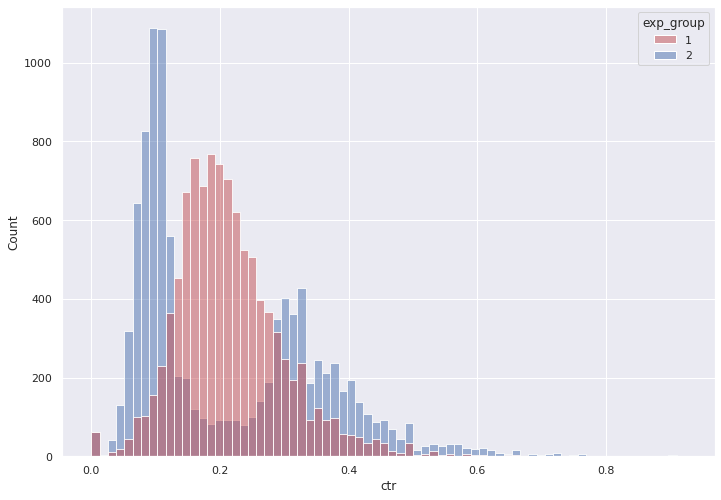

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data = df, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False);

Форма распределения метрики для группы 2 значительно отличается от распределения этого показателя для группы 1. Если для группы 1 распределение больше напоминает нормальное: унимодальное и симметричное, то распределение для группы 2 бимодальное. Такое распределение для 2 группы может говорить о том, что новый алгоритм рекомендаций постов вызвал противоположный эффект у экспериментальной группы, т.е. новый алгоритм для одной части пользователей "снизил" интерес к постам, а для остальной части наоборот "повысил" интерес к постам. Либо такое распределение может говорить об ошибках разбиения пользователей.  Но мы проверяли нашу систему сплитования, она должна работать корректно.

Глядя на график мы можем сделать предположение, что CTR в наших группах отличается. Проверим это утверждение с помощью статистических тестов.

## Выбор метода тестирования

- **Тест t-критерий Стьюдента** в данном случе нам не подойдет т.к. распределение 2 группы бимодально и имеет достаточно много выбросов.  
- **Тест Манна-Уитни** можно использовать т.к. не сильно привязан к распределению метрики.  
- **t-тест на сглаженном CTR** следует применять с осторожностью , т.к. не имеет теоретической обоснованности.   
- **Пуассоновский бутстреп** тоже вполне подходит, выборки достаточно большие и есть достаточный разброс значений.  
- **Бакетное преобразование** можно использовать на наших данных.

## Проведем сравнения всеми указанными тестами

### Тест t-критерий Стьюдента

Сформулируем гипотезы:
$\begin{equation*}
 \begin{cases}
   H_0 :\text{Различий в среднем CTR между группами нет}\\
   H_1 :\text{Различия в среднем CTR между группами есть}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

In [4]:
alpha = .05

results = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4780623130874935
Не получилось отвергнуть нулевую гипотезу


**Вывод:**  
На анализируемых данных t-критерий Стьюдента не выявил статистически значимых различий. Но мы должны относится к этому результату скептически, так как распределение показателя группы имело достаточное количество выбросов справа, что повлияло на результаты.

### Тест Манна-Уитни

Сформулируем гипотезы:
$\begin{equation*}
 \begin{cases}
   H_0 :\text{Распределение CTR в первой выборке соответствует распределению CTR во второй выборке}\\
   H_1 :\text{Распределение CTR в первой выборке НЕ соответствует распределению CTR во второй выборке}
 \end{cases}
\end{equation*}$


Уровень значимости: $\alpha = 0.05$

In [5]:
alpha = .05

results = stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  6.0376484617779035e-56
Отвергаем нулевую гипотезу


**Вывод:**  
Тест Манна-Уитни в свою очередь выявил статистически значимое отличие в группах. Не смотря на то что отличия в средних нет (как показал т-тест), различия в распределениях тест Манна-Уитни обнаружил. Действительно распределения на графике отличаются.

### t-тест на сглаженном CTR

Сгладим оценки CTR:

In [6]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [7]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [8]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

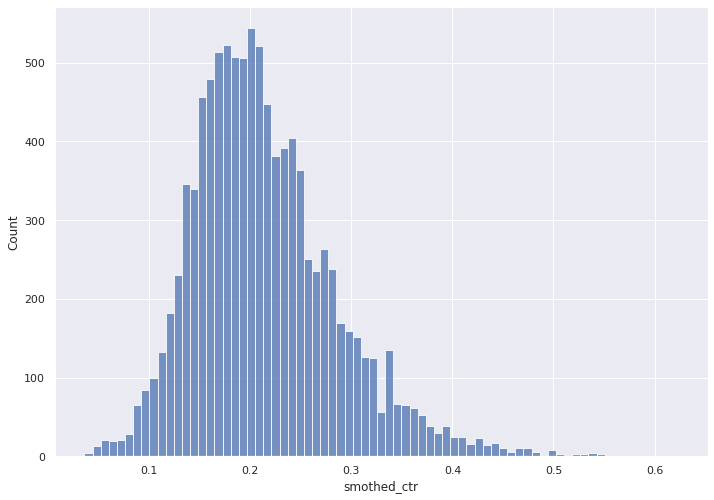

In [9]:
# применим функцию к каждому юзеру группы функцию, установим значение гиперпарамметра - "5".
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
sns.histplot(group1['smothed_ctr']); # построим распределение поюзерного сглаженного CTR

Повторим все тоже самое для второй группы:

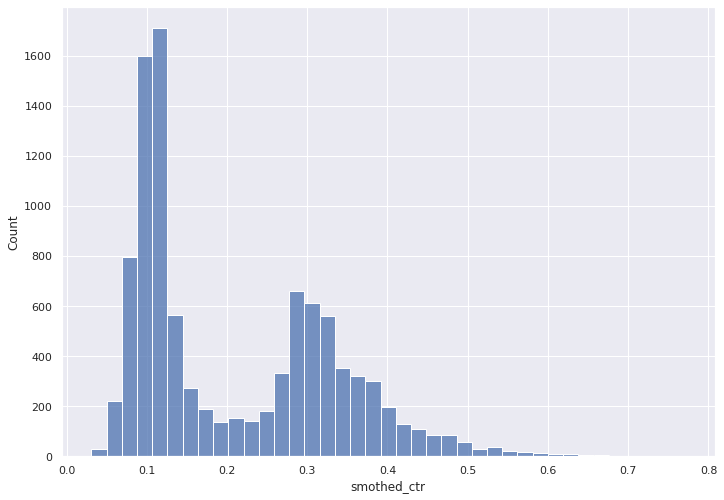

In [10]:
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
sns.histplot(group2['smothed_ctr']);

**А теперь проверим с помощью t-теста полученные данные:**

In [11]:
alpha = .05

results = stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.0223769815558559
Отвергаем нулевую гипотезу


**Вывод:**  
На сглаженном CTR t-тест показал другой результат. В этом случае мы отвергаем Нулевую гипотезу.

### Пуассоновский бутстреп

Обьявим функцию для расчета глобального CTR для каждой повыборки

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [13]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [14]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

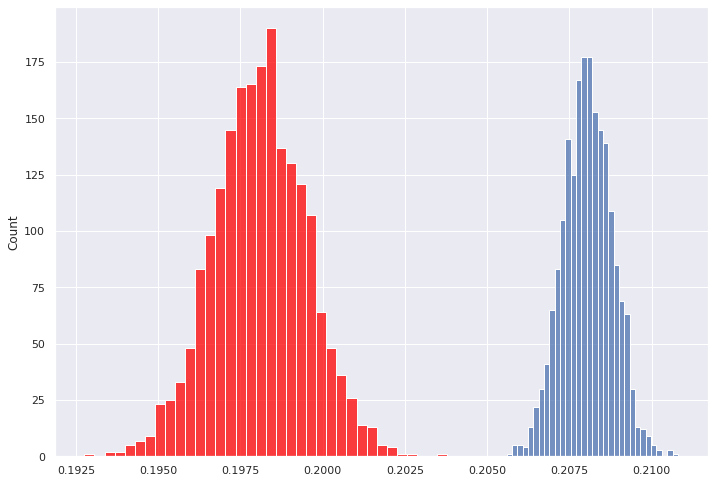

In [15]:
sns.histplot(ctr1)
sns.histplot(ctr2, color="red");

Мы видим что в результате сравнения групповой CTR в тестовой группе оказался ниже, чем в контрольной. Распределния достаточно близки, но не пересекаются.

Построим распределение разницы между глобальными CTR

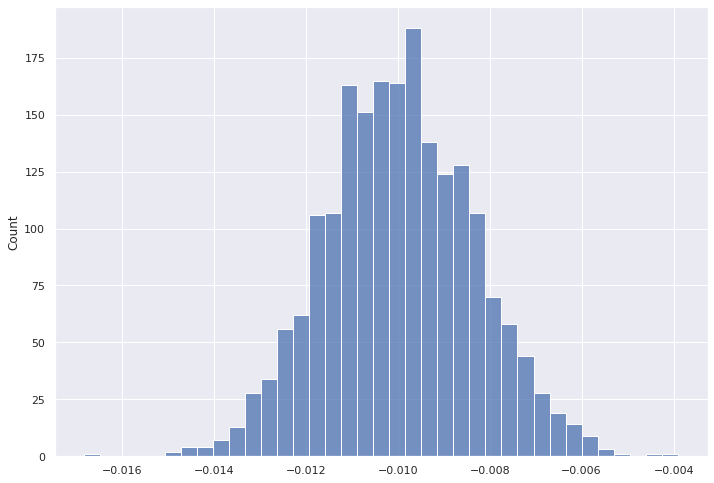

In [16]:
sns.histplot(ctr2 - ctr1);

**Вывод:**  
Распределение разницы лежит слева от нуля, что позволяет нам сказать что CTR группы `2` меньше CTR группы `1`.

### Бакетное преобразование

Применим бакетное преобразование к нашим выборкам. Разделимнаши выборки на 50 корзин, и для каждой корзины посчитаем CTR.

In [17]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr    
    FROM (SELECT exp_group,
    xxHash64(user_id)%50 as bucket,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
and exp_group in (1,2)
GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
dfb = ph.read_clickhouse(q, connection=connection)
dfb.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


**Поверх такого преобразования применим тест Манна-Уитни:**

In [18]:
alpha = .05

results = stats.mannwhitneyu(dfb[dfb.exp_group == 1].bucket_ctr, dfb[df.exp_group == 2].bucket_ctr, alternative = 'two-sided')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.9203931776114523e-05
Отвергаем нулевую гипотезу


Посмотрим на распределение бакетного CTR в подвыборках:

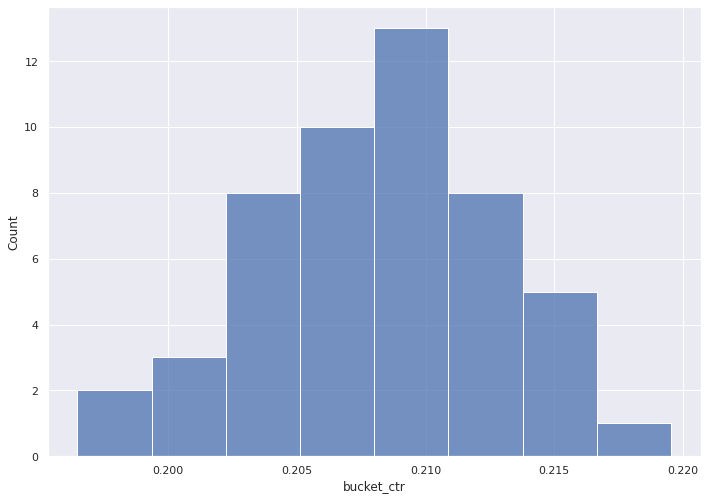

In [19]:
sns.histplot(dfb[dfb.exp_group == 1].bucket_ctr);

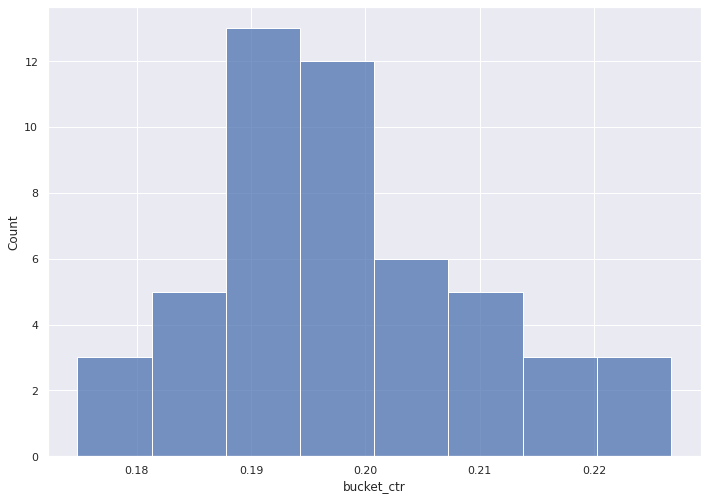

In [20]:
sns.histplot(dfb[dfb.exp_group == 2].bucket_ctr);

Распределения метрик стали немного напоминать нормальное распределение. Можно попробовать приметить Тест t-критерий Стьюдента.

In [21]:
alpha = .05

results = stats.ttest_ind(dfb[dfb.exp_group == 1].bucket_ctr, dfb[dfb.exp_group == 2].bucket_ctr, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  3.4455951649945907e-07
Отвергаем нулевую гипотезу


**Вывод:**  
И t-тест и тест Манна-Уитни после бакетного преобразования определили статистически значимые различия.

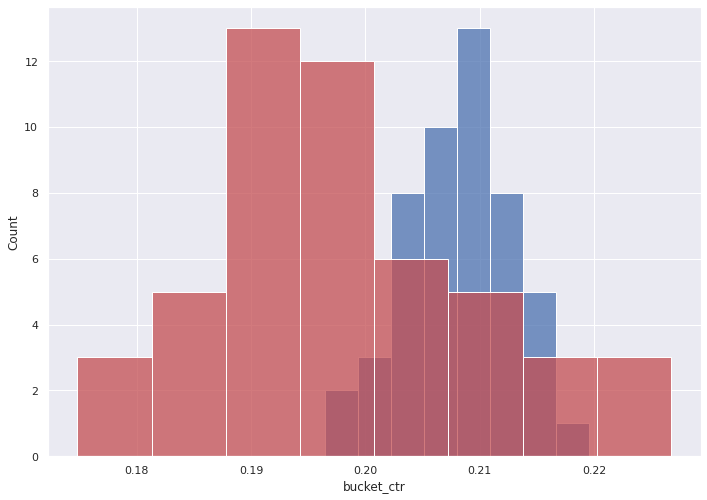

In [22]:
sns.histplot(dfb[dfb.exp_group == 1].bucket_ctr)
sns.histplot(dfb[dfb.exp_group == 2].bucket_ctr, color='r');

Распределение бакетного CTR тестовой группы расположено левее ближе к нулю. Чтоговорит о том что показатель 2-йгруппы меньше, чем у 1-й.

## Общий вывод

Мы провели анализ результатов А/В теста разными тестами, и почти все тесты указали на наличие значимой разницы. Основываясь на результатах тестов и построенных графиках можно сказать, что новая система рекомендаций во 2-й группе не привела к увеличению CTR. И если мы посмотрим на результаты Пауссоновского Бутстрепа, то можем сказать, что CTR во 2-группе снизился.   
Мы видим, что для определенной части пользователей новая система "повысила" интерес к постам, но в целом для группы эффект оказался отрицательным. Определенно стоит дополнительно исследовать новую систему рекомендаций и понять за счет чего для части пользователей она оказалась более эффективной. Но не стоит раскатывать новый алгоритм в этом виде на всех новых пользователей.